In [59]:
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional, List
import numpy as np
import math
import torch
import torch.nn as nn
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

In [60]:
#@markdown ### **Network**
#@markdown
#@markdown Defines a 1D UNet architecture `ConditionalUnet1D`
#@markdown as the noies prediction network
#@markdown
#@markdown Components
#@markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
#@markdown - `Downsample1d` Strided convolution to reduce temporal resolution
#@markdown - `Upsample1d` Transposed convolution to increase temporal resolution
#@markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
#@markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
#@markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
#@markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


In [62]:
#@markdown ### **Network Demo**

# observation and action dimensions corrsponding to
# the output of PushTEnv
# obs_dim = 25
# action_dim = 13

obs_dim = 7
action_dim = 4
# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
sample_size = 8

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

number of parameters: 6.541415e+07


In [78]:
#@markdown ### **Dataset**
#@markdown
#@markdown Defines `PushTStateDataset` and helper functions
#@markdown
#@markdown The dataset class
#@markdown - Load data (obs, action) from a zarr storage
#@markdown - Normalizes each dimension of obs and action to [-1,1]
#@markdown - Returns
#@markdown  - All possible segments with length `pred_horizon`
#@markdown  - Pads the beginning and the end of each episode with repetition
#@markdown  - key `obs`: shape (obs_horizon, obs_dim)
#@markdown  - key `action`: shape (pred_horizon, action_dim)

import numpy as np
import torch
import pandas as pd
import re
import random
# from robodk import robolink    # RoboDK API
from robomath import *   # Robot toolbox

def distance(current, next):
    distance = math.sqrt((next[0] - current[0])**2 + (next[1] - current[1])**2 + (next[2] - current[2])**2)
    return distance

def sampler(data, sample_size):
    sam = []
    for i in range(0, len(data)):
        if i% sample_size == 0:
            sam.append(data[i])
    # print(sam)
    return sam


def euler_change(Gwxyz):
    quaternion = np.array(Gwxyz)
    euler_angles = []

    for i in range(len(quaternion)):
        # Create a Rotation object from the quaternion
        pos_i = quaternion_2_pose(quaternion[i])
        # print("pos_i")
        # print(pos_i)
        eul_i = pose_2_xyzrpw(pos_i)
        # print("eul_i")
        # print(eul_i)
        # Convert to Euler angles (in radians)
        euler_angles.append(eul_i[3:])  # 'xyz' specifies the order of rotations

    return euler_angles

def extract_data(result_dict, sample_size):


    GXYZ, Gwxyz, SXYZ, Swxyz, BXYZ, Bwxyz, DXYZ, Dwxyz  = [], [], [], [], [], [], [], []
    indexes = []
    diff = []
    mins = []
    value_to_indexes = {}
    indexes_in_list2 = []

    for key in result_dict:
        path_value = result_dict[key]['Path']
        start = int(result_dict[key]['start_frame'])
        end = int(result_dict[key]['end_frame'])

        data  = pd.read_csv(path_value)
        data = data.reset_index(drop=False)
        data = data.drop(index =0)
        data = data.drop(index =2)
        data = data.reset_index(drop=True)

        row1 = data.iloc[0]
        row2 = data.iloc[1]
        row3 = data.iloc[2]

        combined_values = []
        for a, b, c in zip(row1, row2, row3):
            combined_values.append(str(a) + '_' + str(b) + '_' + str(c))

        data.columns = combined_values
        data = data.drop(index =0)
        data = data.drop(index =1)
        data = data.drop(index =2)
        data = data.drop(data.columns[:2], axis=1)
        # print(result_dict)
        data = data.iloc[start:end]
        data = data.dropna()
        data = data.reset_index(drop=True)

        # Regular expression pattern to match columns starting with 'gripper_1_Rotation'
        pattern1 = re.compile(r'GRIPPER_2_Rotation')
        pattern2 = re.compile(r'GRIPPER_2_Position')
        pattern3 = re.compile(r'diff_scooper_2_2_Rotation')
        pattern4 = re.compile(r'diff_scooper_2_2_Position')
        pattern5 = re.compile(r'box3_Rotation')
        pattern6 = re.compile(r'box3_Position')
        pattern7 = re.compile(r'bucket_SC_Rotation')
        pattern8 = re.compile(r'bucket_SC_Position')

        # Filter columns using regex pattern and extract values into a list
        a = data.filter(regex=pattern1).values.astype('float64').tolist()
        a = sampler(a, sample_size)
        b = data.filter(regex=pattern2).values.astype('float64').tolist()
        b = sampler(b, sample_size)
        c = data.filter(regex=pattern3).values.astype('float64').tolist()
        c = sampler(c, sample_size)
        d = data.filter(regex=pattern4).values.astype('float64').tolist()
        d = sampler(d, sample_size)
        e = data.filter(regex=pattern5).values.astype('float64').tolist()
        e = sampler(e, sample_size)
        f = data.filter(regex=pattern6).values.astype('float64').tolist()
        f = sampler(f, sample_size)
        g = data.filter(regex=pattern7).values.astype('float64').tolist()
        g = sampler(g, sample_size)
        h = data.filter(regex=pattern8).values.astype('float64').tolist()
        h = sampler(h, sample_size)

        for sublist in b:
            y = sublist[0] 
            z= sublist[1]
            x = sublist[2]
            sublist[0] = x
            sublist[1] = y
            sublist[2] = z    

        for sublist in d:
            y = sublist[0]
            z= sublist[1]
            x = sublist[2]
            sublist[0] = x
            sublist[1] = y
            sublist[2] = z  

        for sublist in f:
            y = sublist[0]
            z= sublist[1]
            x = sublist[2]
            sublist[0] = x
            sublist[1] = y
            sublist[2] = z  

        for sublist in h:
            y = sublist[0]
            z= sublist[1]
            x = sublist[2]
            sublist[0] = x
            sublist[1] = y
            sublist[2] = z  

        for sublist in a:
            y = sublist[0]
            z = sublist[1]
            x = sublist[2]
            w = sublist[3]
            sublist[0] = w
            sublist[1] = x
            sublist[2] = y    
            sublist[3] = z    

        a = euler_change(a)
        # print(a)

        for sublist in c:
            y = sublist[0]
            z = sublist[1]
            x = sublist[2]
            w = sublist[3]
            sublist[0] = w
            sublist[1] = x
            sublist[2] = y    
            sublist[3] = z   

        c = euler_change(c)

        for sublist in e:
            y = sublist[0]
            z = sublist[1]
            x = sublist[2]
            w = sublist[3]
            sublist[0] = w
            sublist[1] = x
            sublist[2] = y    
            sublist[3] = z  

        e = euler_change(e)

        for sublist in g:
            y = sublist[0]
            z = sublist[1]
            x = sublist[2]
            w = sublist[3]
            sublist[0] = w
            sublist[1] = x
            sublist[2] = y    
            sublist[3] = z

        g = euler_change(g)

        GXYZ.extend(b)
        indexes.append(len(GXYZ))
        Gwxyz.extend(a)
        SXYZ.extend(d)
        Swxyz.extend(c)
        BXYZ.extend(f)
        Bwxyz.extend(e)
        DXYZ.extend(h)
        Dwxyz.extend(g)


    for i in range(min(len(GXYZ), len(BXYZ))):
        diff_s = distance(GXYZ[i], BXYZ[i])
        diff.append(diff_s)

    GA = np.full_like(diff, -1)
    min_values = sorted(set(diff))

    for index, value in enumerate(min_values):
        if value < 0.01:
            mins.append(value)
            
    # Populate the dictionary with list2 values and their indexes
    for index, value in enumerate(diff):
        if value in value_to_indexes:
            value_to_indexes[value].append(index)
        else:
            value_to_indexes[value] = [index]

    # Find indexes in list2 corresponding to values in list1
    for value in mins:
        if value in value_to_indexes:
            indexes_in_list2.extend(value_to_indexes[value])

    for i in range (min(indexes_in_list2), max(indexes_in_list2)+1):
        GA[i] = 1

    # return  b, a, d, c, f, e, h, g
    return GXYZ, Gwxyz, SXYZ, Swxyz, BXYZ, Bwxyz, DXYZ, Dwxyz, indexes, GA.tolist()

def generate_sequential_random_sequence(max_value):
    random_sequence = []
    current_value = 0
    
    while current_value < max_value:
        # Generate a random increment (not exceeding 1000 to ensure it doesn't jump too far)
        increment = random.randint(1, min(200, max_value - current_value))
        current_value += increment
        random_sequence.append(current_value)
    
    # If the last value is more than max_value, remove it
    if random_sequence[-1] > max_value:
        random_sequence.pop()
    
    return random_sequence

def create_sample_indices(
        episode_ends:np.ndarray, sequence_length:int,
        pad_before: int=0, pad_after: int=0):
    indices = []
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        # print("Start min",min_start)
        max_start = episode_length - sequence_length + pad_after
        # print("Start max",max_start)

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

# normalize data
def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# dataset
class RealStateDataset(torch.utils.data.Dataset):
    def __init__(self, dataset,  base_path,
                 pred_horizon, obs_horizon, action_horizon, sample_size):
        
        # read from zarr dataset
        list = dataset
        # Base path
        collums = list.columns

        result_dict = {}
        count = 0
        for i in range(len(list)):
            if list[collums[3]][i] == 'accept':
                result_dict[count] = {
                    'Path': base_path + str(list[collums[0]][i]) + '.csv',
                    'start_frame': list[collums[1]][i],
                    'end_frame': list[collums[2]][i],
                    'Note': list[collums[4]][i]
                }
                count += 1

        # for key in result_dict:
        GXYZ, Gwxyz, SXYZ, Swxyz, BXYZ, Bwxyz, DXYZ, Dwxyz, index , GA = extract_data(result_dict, sample_size)

        action = []
        obs = []
        for i in range(len(GXYZ)):
            a = []
            # a = Gwxyz[i] + GXYZ[i] + Swxyz[i] + SXYZ[i]
            a.extend(GXYZ[i])
            # print(GXYZ[i])
            # print(a)
            a.append(GA[i])
            # print(a)
            # b = Gwxyz[i] + GXYZ[i] + Swxyz[i] + SXYZ[i] + Dwxyz[i] + DXYZ[i] + Bwxyz[i] + BXYZ[i]
            b =  GXYZ[i] + BXYZ[i]
            b.append(GA[i])
            # print(b)
            action.append(a)
            obs.append(b)

    # All demonstration episodes are concatinated in the first dimension N
        action = np.array(action, dtype=np.float64)
        obs = np.array(obs, dtype=np.float64)
        train_data = {
            # (N, action_dim)
            'action': action[:],
            # (N, obs_dim)
            'obs': obs[:]
        }

        # Marks one-past the last index for each episode
        # episode_ends = generate_sequential_random_sequence(3585)
        episode_len = index
        print(episode_len)

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_len,
            sequence_length=pred_horizon,
            # add padding such that each timestep in the dataset are seen
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)
        
        # print(indices.shape)
        # print(len(indices))
        # print(indices[:5])
        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        # all possible segments of the dataset
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get nomralized data using these indices
        # print("gett item")
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        nsample['obs'] = nsample['obs'][:self.obs_horizon,:]
        return nsample
    
# dataset
class PushTStateDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path,
                 pred_horizon, obs_horizon, action_horizon):

        # read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')
        # All demonstration episodes are concatinated in the first dimension N
        train_data = {
            # (N, action_dim)
            'action': dataset_root['data']['action'][:],
            # (N, obs_dim)
            'obs': dataset_root['data']['state'][:]
        }
        # Marks one-past the last index for each episode
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            # add padding such that each timestep in the dataset are seen
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)

        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        # all possible segments of the dataset
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get nomralized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        nsample['obs'] = nsample['obs'][:self.obs_horizon,:]
        return nsample



TBLOCK

In [6]:
import os
# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTStateDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['obs'].shape: torch.Size([256, 2, 5])
batch['action'].shape torch.Size([256, 16, 2])


HANDOVER

In [79]:

# create dataset from file
path_name = "/home/cam/Documents/test_mujoco_2/Archive/Supporting Data - Sheet1.csv"
base_path = "/home/cam/Documents/test_mujoco_2/Archive/sean & Li 2 exports/"
data = pd.read_csv(path_name)
split_index = int(len(data) * 0.8)

# Split DataFrame
train_df = data.iloc[:split_index]
test_df = data.iloc[split_index:]
test_df.reset_index(drop=True, inplace=True)

dataset_train = RealStateDataset(
    dataset=train_df,
    base_path=base_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
    sample_size=sample_size
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)


batch = next(iter(dataloader_train))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

[167, 317, 470, 618, 748, 896, 1028, 1170, 1315, 1447, 1579, 1719, 1851, 1999, 2151, 2272, 2416, 2561, 2693, 2838, 2958, 3080, 3212, 3344, 3471, 3609, 3726, 3856, 3978, 4108, 4245, 4372, 4488, 4620, 4746, 4901, 5041, 5186, 5342, 5474, 5610, 5728, 5843, 5993, 6101, 6216, 6334, 6473, 6596, 6709, 6836, 6964, 7095, 7243, 7357, 7482, 7605, 7725, 7848, 7971, 8096, 8212, 8331, 8460, 8582, 8709, 8863, 9005, 9132, 9237, 9355, 9469, 9588, 9678, 9802, 9937, 10065, 10202, 10329, 10447, 10567, 10711, 10831, 10959, 11086, 11207, 11308, 11434, 11567, 11692, 11816, 11931, 12055, 12188, 12307, 12420, 12563, 12681, 12808, 12924, 13042, 13154, 13274, 13393, 13559, 13676, 13786, 13903, 14026, 14169, 14299, 14421, 14539, 14658, 14770, 14894, 15012, 15137, 15251, 15388, 15530, 15657, 15796, 15930, 16088, 16225]
batch['obs'].shape: torch.Size([256, 2, 7])
batch['action'].shape torch.Size([256, 16, 4])


# MODEL TRAINING

dataloaders = dataloader ## PUSH T data loader

dataloaders = dataloader_train ## handoverTask data loader

In [81]:
# dataloaders = dataloader 
dataloaders = dataloader_train 

In [82]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about an hour. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights
import os
import time

num_epochs = 200
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_interval = 3600
last_checkpoint_time = time.time()
# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    model=noise_pred_net,
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=len(dataloaders) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    epoch_loss = []
    batch_loss_per_epoch = []

    for epoch_idx in tglobal:
        batch_loss = []
        batch_noise = []
        # batch loop
        with tqdm(dataloaders, desc='Batch', leave=False) as tepoch:

            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                # nobs = nbatch['obs'].to(device)
                # naction = nbatch['action'].to(device)
                nobs = nbatch['obs']
                naction = nbatch['action']
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1).float().to(device)
                # print(obs_cond.type())

                # sample noise to add to actions
                # noise = torch.randn(naction.shape, device=device)
                noise = torch.randn(naction.shape)

                # sample a diffusion iteration for each data point
                # timesteps = torch.randint(
                #     0, noise_scheduler.config.num_train_timesteps,
                #     (B,), device=device
                # ).long()

                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,)
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)
                
                noise = noise.to(device)
                
                timesteps = timesteps.to(device)

                # print(noisy_actions.type())
                noisy_actions = noisy_actions.type(torch.FloatTensor).to(device)
                # print(noisy_actions.type())

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)
                batch_noise.append(noise_pred)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net)
                # print(ema.state_dict)

                # logging
                loss_cpu = loss.item()
                batch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # save checkpoint
        # went to the emma model library and added state_dict to the model
        current_time = time.time()
        if current_time - last_checkpoint_time > checkpoint_interval:
        # if epoch_idx == 2:
            # Save model checkpoint
            # checkpoint_path = os.path.join(checkpoint_dir, f'BOX_GRIP_checkpoint_epoch_{epoch_idx}.pth')
            checkpoint_path = os.path.join(checkpoint_dir, f'T_checkpoint_epoch_{epoch_idx}.pth')

            torch.save({
                'epoch': epoch_idx,
                'model_state_dict': noise_pred_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'ema_state_dict': ema.state_dict,
                'loss': loss.cpu().detach().numpy(),
            }, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch_idx}')
            last_checkpoint_time = current_time
        elif epoch_idx == num_epochs:
            # Save model checkpoint
            # checkpoint_path = os.path.join(checkpoint_dir, f'BOX_GRIP_checkpoint_epoch_{epoch_idx}.pth')
            checkpoint_path = os.path.join(checkpoint_dir, f'T_checkpoint_epoch_{epoch_idx}.pth')
            torch.save({
                'epoch': epoch_idx,
                'model_state_dict': noise_pred_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'ema_state_dict': ema.state_dict,
                'loss': loss.cpu().detach().numpy(),
            }, checkpoint_path)
            print(f'Checkpoint saved at epoch {epoch_idx}')
            last_checkpoint_time = current_time
            
        tglobal.set_postfix(loss=np.mean(batch_loss))
        epoch_loss.append(np.mean(batch_loss))
        batch_loss_per_epoch.append(batch_loss)

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = noise_pred_net
# ema.copy_to(ema_noise_pred_net.parameters())

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:   0%|          | 1/200 [02:13<7:22:43, 133.48s/it, loss=0.847]

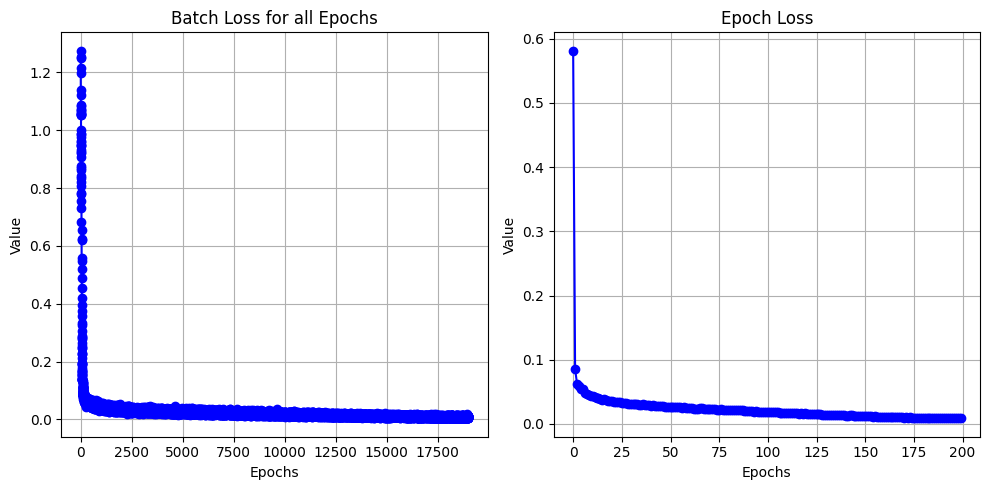

In [58]:
# Create a figure and axis
import matplotlib.pyplot as plt


flatten_loss = np.array(batch_loss_per_epoch)

flatten_loss = flatten_loss.flatten()
# Define subplots correctly
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for the first subplot (ax1)
ax1.plot(flatten_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the first subplot (ax1)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Value')
ax1.set_title('Batch Loss for all Epochs')
ax1.grid(True)
# ax1.legend()

# Plot for the second subplot (ax2)
ax2.plot(epoch_loss, marker='o', linestyle='-', color='b', label='Values')

# Customize the second subplot (ax2)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Value')
ax2.set_title('Epoch Loss')
ax2.grid(True)
# ax2.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# checkpoint = torch.load(checkpoint_path)

# # Load model state
# noise_pred_net.load_state_dict(checkpoint['model_state_dict'])

# # Load optimizer state
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Load LR scheduler state (if applicable)
# lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

# # Load EMA model state
# ema.load_state_dict(checkpoint['ema_state_dict'])

# # Optionally, retrieve other information such as epoch and loss
# epoch_loaded = checkpoint['epoch']
# loss_loaded = checkpoint['loss']

#EVALUATION

Test Hand over data Set

In [ ]:
test_df

In [ ]:
list = test_df
# Base path
base_path = "/home/cam/Documents/test_mujoco_2/Archive/sean & Li 2 exports/"
collums = list.columns

result_dict = {}
count = 0
for i in range(len(list)):
    if list[collums[3]][i] == 'accept':
        result_dict[count] = {
            'Path': base_path + str(list[collums[0]][i]) + '.csv',
            'start_frame': list[collums[1]][i],
            'end_frame': list[collums[2]][i],
            'Note': list[collums[4]][i]
        }
        count += 1

# for key in result_dict:
GXYZ, Gwxyz, SXYZ, Swxyz, BXYZ, Bwxyz, DXYZ, Dwxyz, index , GA = extract_data(result_dict, sample_size)

action = []
obs = []
    
for i in range(len(GXYZ)):
    a = Gwxyz[i] + GXYZ[i]
    a.append(GA[i])
    b = Gwxyz[i] + GXYZ[i] + Bwxyz[i] + BXYZ[i]
    b.append(GA[i])
    action.append(a)
    obs.append(b)

# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)
test_data = {
    # (N, action_dim)
    'action': action[:],
    # (N, obs_dim)
    'obs': obs[:]
}

# Marks one-past the last index for each episode
# episode_ends = generate_sequential_random_sequence(3585)
episode_ends = index
print(type(episode_ends))

In [ ]:
splits_obs = []
splits_action = []
previous_index = 0

# Iterate through index_ranges and slice combined_list accordingly
for index in episode_ends:
    splits_obs.append(test_data['obs'][previous_index:index + 1])  # Include index itself in the slice
    splits_action.append(test_data['action'][previous_index:index + 1])
    previous_index = index + 1

Train Handover data Set

In [ ]:
train_df

In [ ]:
list = train_df
# Base path
base_path = "/home/cam/Documents/test_mujoco_2/Archive/sean & Li 2 exports/"
collums = list.columns

result_dict = {}
count = 0
for i in range(len(list)):
    if list[collums[3]][i] == 'accept':
        result_dict[count] = {
            'Path': base_path + str(list[collums[0]][i]) + '.csv',
            'start_frame': list[collums[1]][i],
            'end_frame': list[collums[2]][i],
            'Note': list[collums[4]][i]
        }
        count += 1

# for key in result_dict:
GXYZ, Gwxyz, SXYZ, Swxyz, BXYZ, Bwxyz, DXYZ, Dwxyz, index , GA = extract_data(result_dict, sample_size)

action = []
obs = []
    
for i in range(len(GXYZ)):
    a = Gwxyz[i] + GXYZ[i] + Swxyz[i] + SXYZ[i]
    a.append(GA[i])
    b = Gwxyz[i] + GXYZ[i] + Swxyz[i] + SXYZ[i] + Dwxyz[i] + DXYZ[i] + Bwxyz[i] + BXYZ[i]
    b.append(GA[i])
    action.append(a)
    obs.append(b)

# All demonstration episodes are concatinated in the first dimension N
action = np.array(action, dtype=np.float64)
obs = np.array(obs, dtype=np.float64)
val_data = {
    # (N, action_dim)
    'action': action[:],
    # (N, obs_dim)
    'obs': obs[:]
}

# Marks one-past the last index for each episode
# episode_ends = generate_sequential_random_sequence(3585)
episode_ends = index
print(type(episode_ends))

In [ ]:
splits_val_obs = []
splits_val_action = []
previous_index = 0

# Iterate through index_ranges and slice combined_list accordingly
for index in episode_ends:
    splits_val_obs.append(val_data['obs'][previous_index:index + 1])  # Include index itself in the slice
    splits_val_action.append(val_data['action'][previous_index:index + 1])
    previous_index = index + 1

In [ ]:
len(splits_val_action)

Orignal PusT data task

In [ ]:
import zarr
import matplotlib.pyplot as plt

        # read from zarr dataset
dataset_root = zarr.open(dataset_path, 'r')
# All demonstration episodes are concatinated in the first dimension N
train_data = {
    # (N, action_dim)
    'action': dataset_root['data']['action'][:],
    # (N, obs_dim)
    'obs': dataset_root['data']['state'][:]
}

episode_ends = dataset_root['meta']['episode_ends'][:]

splits_T_obs = []
split_T_action = []
previous_index = 0

# Iterate through index_ranges and slice combined_list accordingly
for index in episode_ends:
    splits_T_obs.append(train_data['obs'][previous_index:index + 1])  # Include index itself in the slice
    split_T_action.append(train_data['action'][previous_index:index + 1])  # Include index itself in the slice
    previous_index = index + 1


# Recheck which datatset are you using because split is getting overwritten

In [ ]:
trajectories = {}
for j in range(len(episode_ends)):
    # get first observation
    com_obs = splits_obs[j]
    obs = splits_obs[j][0]
    actions_test = splits_action[j]
    # max_steps = len(test_data['action'])
    max_steps = len(actions_test)
    stats = dataset.stats
    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)

    # save visualization and rewards
    done = False
    step_idx = 0
    traj = []
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # print("Obs_sep -",obs_seq)
            # normalize observation
            nobs = normalize_data(obs_seq, stats=stats['obs'])
            # print(nobs)
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)
                # print(obs_cond.shape)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, pred_horizon, action_dim), device=device)
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = ema_noise_pred_net(
                        sample=naction,
                        timestep=k,
                        global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred,
                        timestep=k,
                        sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to('cpu').numpy()
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = unnormalize_data(naction, stats=stats['action'])

            # only take action_horizon number of actions
            start = obs_horizon - 1
            end = start + action_horizon
            action = action_pred[start:end,:]
            # print(action[0])
            # print(actions_test[0])
            traj.extend(action)
            losses = []

            # if len(action) <= len(actions_test):
            #     lenths = len(action)

            # else :
            #     lenths = len(actions_test)
                
            for i in range(len(action)):
                # loss
                # print("Action_pred -",action[i])
                # print("Action_orignal -",actions_test[i])
                # print("Obs_added -",com_obs[i])
                if len(action) > len(actions_test):
                    done = True
                if done:
                    break
                loss_test = nn.functional.mse_loss(torch.tensor(action[i]), torch.tensor(actions_test[i]))
                obs_deque.append(com_obs[i])
                losses.append(loss_test.item())
                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(loss=np.mean(losses))
                # print(i)
                if step_idx > max_steps:
                    done = True
                if done:
                    break
            com_obs = com_obs[len(action):]
            actions_test = actions_test[len(action):]
    trajectories[f"{j}"] = traj

In [ ]:
x_coords = [item[0] for item in trajectories[next(iter(trajectories.keys()))]]
y_coords = [item[1] for item in trajectories[next(iter(trajectories.keys()))]]
# z_coords = [item[5] for item in trajectories[next(iter(trajectories.keys()))]]

plt.figure(figsize=(10, 5))

# Plot XYZ coordinates
plt.subplot(1, 2, 1)
plt.plot(range(len(x_coords)), x_coords, label='X', linestyle='-', linewidth=1)  # Adjust line width here
plt.plot(range(len(y_coords)), y_coords, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
# plt.plot(range(len(z_coords)), z_coords, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
plt.legend(loc='upper right')
plt.title(f'Pred - XYZ Coordinates')
plt.xlabel('Frame')
plt.ylabel('Coordinates')

# Plot Euler angles
# roll = [item[0] for item in trajectories[next(iter(trajectories.keys()))]]
# pitch = [item[1] for item in trajectories[next(iter(trajectories.keys()))]]
# yaw = [item[2] for item in trajectories[next(iter(trajectories.keys()))]]

# plt.subplot(1, 2, 2)
# plt.plot(range(len(roll)), roll, label='Roll', linestyle='-', linewidth=1)  # Adjust line width here
# plt.plot(range(len(pitch)), pitch, label='Pitch', linestyle='-', linewidth=1)  # Adjust line width here
# plt.plot(range(len(yaw)), yaw, label='Yaw', linestyle='-', linewidth=1)  # Adjust line width here
# plt.legend(loc='upper right')
# plt.title(f'{next(iter(trajectories.keys()))} - Euler Angles')
# plt.xlabel('Frame')
# plt.ylabel('Euler Angles (Radians)')


x_coords = [item[0] for item in splits_action[0]]
y_coords = [item[1] for item in splits_action[0]]
# z_coords = [item[5] for item in trajectories[next(iter(trajectories.keys()))]]

plt.figure(figsize=(10, 5))

# Plot XYZ coordinates
plt.subplot(1, 2, 2)
plt.plot(range(len(x_coords)), x_coords, label='X', linestyle='-', linewidth=1)  # Adjust line width here
plt.plot(range(len(y_coords)), y_coords, label='Y', linestyle='-', linewidth=1)  # Adjust line width here
# plt.plot(range(len(z_coords)), z_coords, label='Z', linestyle='-', linewidth=1)  # Adjust line width here
plt.legend(loc='upper right')
plt.title(f'Orignal - XYZ Coordinates')
plt.xlabel('Frame')
plt.ylabel('Coordinates')



plt.tight_layout()

In [ ]:
# Read the CSV and extract each row as a list
import csv

# Initialize an empty list to store lists from CSV
lists_from_csv = trajectories[trajectories.keys()[0]]

with open('data1.csv', 'w+') as csvfile:
    writer = csv.writer(csvfile)
    header = ['rx', 'ry', 'rz', 'x', 'y', 'z', 'sx', 'sy', 'sz', 'x', 'y', 'z','GA']
    writer.writerow(header)
    for i in range(len(lists_from_csv)):
        writer.writerow(lists_from_csv[i])

ROBODK

In [ ]:
from robodk import robolink    # RoboDK API
from robodk import robomath    # Robot toolbox
RL = robolink.Robolink()
from robodk import *      # RoboDK API
from robolink import *    # Robot toolbox

In [ ]:

def XYZwxyz_2_Pose(XYZwxyz):
    '''
    XYZwxyz --> Pose (Homegeneous 4X4 Matrix)
    this converts XYZ Quat to corresponding Homogeneous Matrix
    '''
    # print(XYZwxyz[3:])
    _pose_matrix_without_XYZ = quaternion_2_pose(XYZwxyz[3:])
    for i in range(3):
        # print(XYZwxyz[i])
        # print(XYZwxyz[i] - 1000)
        if i == 0:
            _pose_matrix_without_XYZ[i,3] = XYZwxyz[i] - 0
        else:
            _pose_matrix_without_XYZ[i,3] = XYZwxyz[i]
    return _pose_matrix_without_XYZ

def Pose_2_XYZwxyz(pose):
    wxyz=pose_2_quaternion(pose)
    XYZ = [pose[i,3] for i in range(3)]
    return [*XYZ, *wxyz]


def MuJoCo_2_RoboDK(XYZwxyz):
    '''
    MuJoCo(XYZwxyz) --> ROBODK(XYZwxyz)
    this only takes XYZ and Quaternion and converts from MuJoCo(XYZwxyz) to ROBODK(XYZwxyz)
    -----
    converts meter -> millimeter
    '''
    for i in range(3):
        # print("i -",i)
        # print(XYZwxyz[i]) 
        # XYZwxyz[1]= XYZwxyz[1] + 0.07
        XYZwxyz[i]*=1000
        # ccma = CCMA(w_ma=5, w_cc=3)
        # XYZwxyz[i] = ccma.filter(XYZwxyz[i])
    #     print(XYZwxyz[i]) 
    #     print("************")
    # print(XYZwxyz)
    return XYZwxyz


world_frame = RL.Item("dual_arm_station")
robot0 = RL.Item("robot0")
WORLD_T_ROBOT0 = XYZwxyz_2_Pose(MuJoCo_2_RoboDK([0, 0.880, 0, 0, 0, 0, 0]))
# print(f"WORLD_T_ROBOT0:\n\n{WORLD_T_ROBOT0}\n\********\n\n")

robot1 = RL.Item("robot1")
WORLD_T_ROBOT1 = XYZwxyz_2_Pose(MuJoCo_2_RoboDK([0, -0.470, 0.0, 0, 0, 0, 0]))
# print(f"WORLD_T_ROBOT1:\n\n{WORLD_T_ROBOT1}\n\********\n\n")


_TARGET0_parent = RL.Item("targets_robot0"); RL.Delete(_TARGET0_parent) #Clear Worksapce
_robot0_base = RL.Item("robot0_base")
_TARGET0_parent = RL.AddFrame("targets_robot0", itemparent=_robot0_base); _TARGET0_parent.setVisible(False)
_TARGET0_parent.setPose(eye())

_TARGET1_parent = RL.Item("targets_robot1"); RL.Delete(_TARGET1_parent) #Clear Worksapce
_robot1_base = RL.Item("robot1_base")
_TARGET1_parent = RL.AddFrame("targets_robot1", itemparent=_robot1_base); _TARGET1_parent.setVisible(False)
_TARGET1_parent.setPose(eye())


joint_robot0 = []
joint_robot1 = []

ORGINAL traj

In [ ]:

list = test_df
# Base path
base_path = "/home/cam/Documents/test_mujoco_2/Archive/sean & Li 2 exports/"
collums = list.columns

result_dict = {}
count = 0
for i in range(len(list)):
    if list[collums[3]][i] == 'accept':
        result_dict[count] = {
            'Path': base_path + str(list[collums[0]][i]) + '.csv',
            'start_frame': list[collums[1]][i],
            'end_frame': list[collums[2]][i],
            'Note': list[collums[4]][i]
        }
        count += 1

# for key in result_dict:
GXYZ, Grxyz, SXYZ, Srxyz, BXYZ, Brxyz, DXYZ, Drxyz, index , GA = extract_data(result_dict, sample_size)
count_g = 0
count_s = 0

for index, _ in enumerate(zip(GXYZ, Grxyz, SXYZ, Srxyz)):

    # if index >= 2020 and index <= 2150:
    if index <= 127:

        print(index)
        # print("SCOOPER-",[*SXYZ[index] , *Swxyz[index]])
        _TARGET0_index_XYZrxyz = MuJoCo_2_RoboDK([*SXYZ[index] , *Srxyz[index]])
        print("TARGET0 -",_TARGET0_index_XYZrxyz)
        _TARGET0 = RL.AddTarget(str(f'test-{index}'), itemparent=_TARGET0_parent, itemrobot=robot0)
        _TARGET0.setPoseAbs(xyzrpw_2_pose(_TARGET0_index_XYZrxyz))
        count_s += 1

        # print("GRIPPER -",[*GXYZ[index] , *Gwxyz[index]])
        _TARGET1_index_XYZrxyz = MuJoCo_2_RoboDK([*GXYZ[index] , *Grxyz[index]])
        print("TARGET1 -",_TARGET1_index_XYZrxyz)
        _TARGET1 = RL.AddTarget(str(f'test-{index}'), itemparent=_TARGET1_parent, itemrobot=robot1)
        _TARGET1.setPoseAbs(xyzrpw_2_pose(_TARGET1_index_XYZrxyz))
        count_g += 1
    
print(f"Total Gripper Targets: {count_g}")
print(f"Total Scooper Targets: {count_s}")


In [ ]:
len(GXYZ)

Predicted Traj

In [ ]:
break_point=0
# for key in result_dict:
for key in trajectories:

    count_g = 0
    count_s = 0
    # break_point += 1
    if break_point == 1:
        break
    print("Break_point -",break_point)
    cartesian_pose0= []
    cartesian_pose1= []
    for index, value in enumerate(trajectories[key]):
        Grxyz = value[:3]
        GXYZ = value[3:6]
        Srxyz = value[6:9]
        SXYZ = value[9:12]

        _TARGET0_index_XYZrxyz = MuJoCo_2_RoboDK([*SXYZ , *Srxyz])
        print("TARGET0 -",_TARGET0_index_XYZrxyz)
        _TARGET0 = RL.AddTarget(str(f'test-{index}'), itemparent=_TARGET0_parent, itemrobot=robot0)
        _TARGET0.setPoseAbs(xyzrpw_2_pose(_TARGET0_index_XYZrxyz))
        count_s += 1

        # print("GRIPPER -",[*GXYZ[index] , *Gwxyz[index]])
        _TARGET1_index_XYZrxyz = MuJoCo_2_RoboDK([*GXYZ , *Grxyz])
        print("TARGET1 -",_TARGET1_index_XYZrxyz)
        _TARGET1 = RL.AddTarget(str(f'test-{index}'), itemparent=_TARGET1_parent, itemrobot=robot1)
        _TARGET1.setPoseAbs(xyzrpw_2_pose(_TARGET1_index_XYZrxyz))
        count_g += 1
    break_point += 1
    